In [1]:
import time
import os
import hashlib
import platform
import psutil
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict, defaultdict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

In [2]:
image_paths = glob.glob('/kaggle/input/brain-tumor-mri-images-44c/*/*.jpg')
class_folders = [os.path.basename(os.path.dirname(p)) for p in image_paths]

# Extract label from folder name
df = pd.DataFrame({
    'image_path': image_paths,
    'label': [os.path.basename(os.path.dirname(p)) for p in image_paths]
})

In [3]:
def get_image_hash(path):
    with open(path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

df['hash'] = df['image_path'].apply(get_image_hash)


df.head()

,image_path,label,hash
0,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma T2,49039eb2c46365a214076655a2471306
1,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma T2,ba8d4823c3f7b944d0b9a59ada499d0a
2,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma T2,88345594ade7062a9df84c2185a12a7b
3,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma T2,21066c609a211320b8de95b864253287
4,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma T2,f967843a3ac107f76ed635feac30bc62


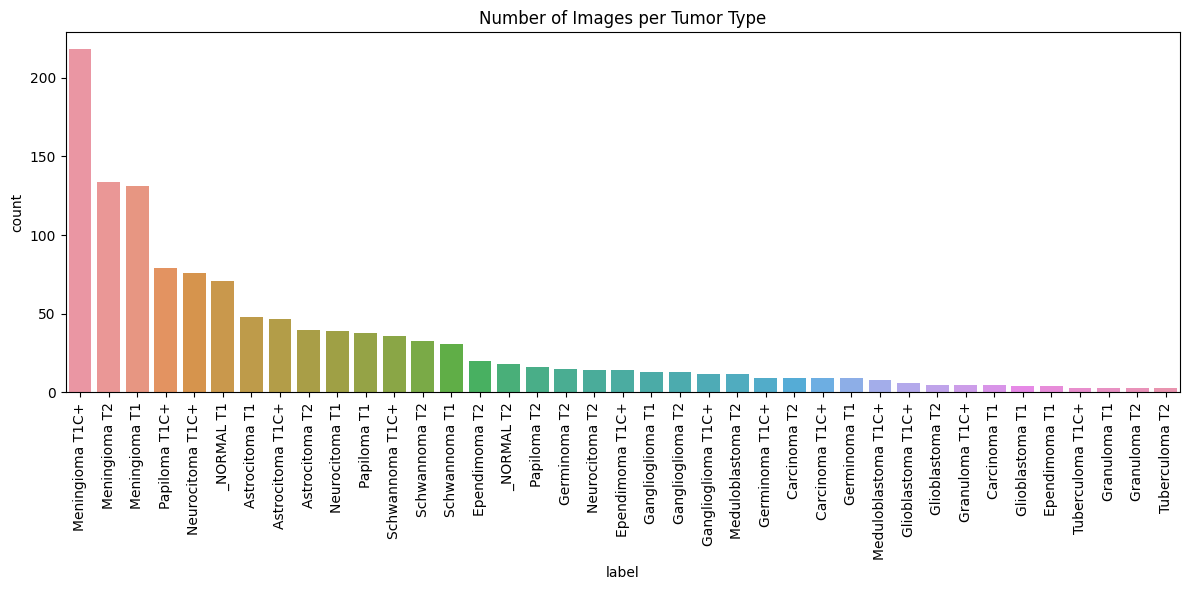

In [4]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title("Number of Images per Tumor Type")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [5]:
class_counts = defaultdict(int)

for path in image_paths:
    label = os.path.basename(os.path.dirname(path))
    class_counts[label] += 1

print(f"Classes with ≥1 image: {len(class_counts)}")
all_class_folders = os.listdir('/kaggle/input/brain-tumor-mri-images-44c')
missing_classes = [cls for cls in all_class_folders if class_counts[cls] == 0]
print("Classes with 0 images:", missing_classes)

Classes with ≥1 image: 39
Classes with 0 images: ['Oligodendroglioma T1C+', 'Tuberculoma T1', 'Meduloblastoma T1', 'Oligodendroglioma T2', 'Oligodendroglioma T1']


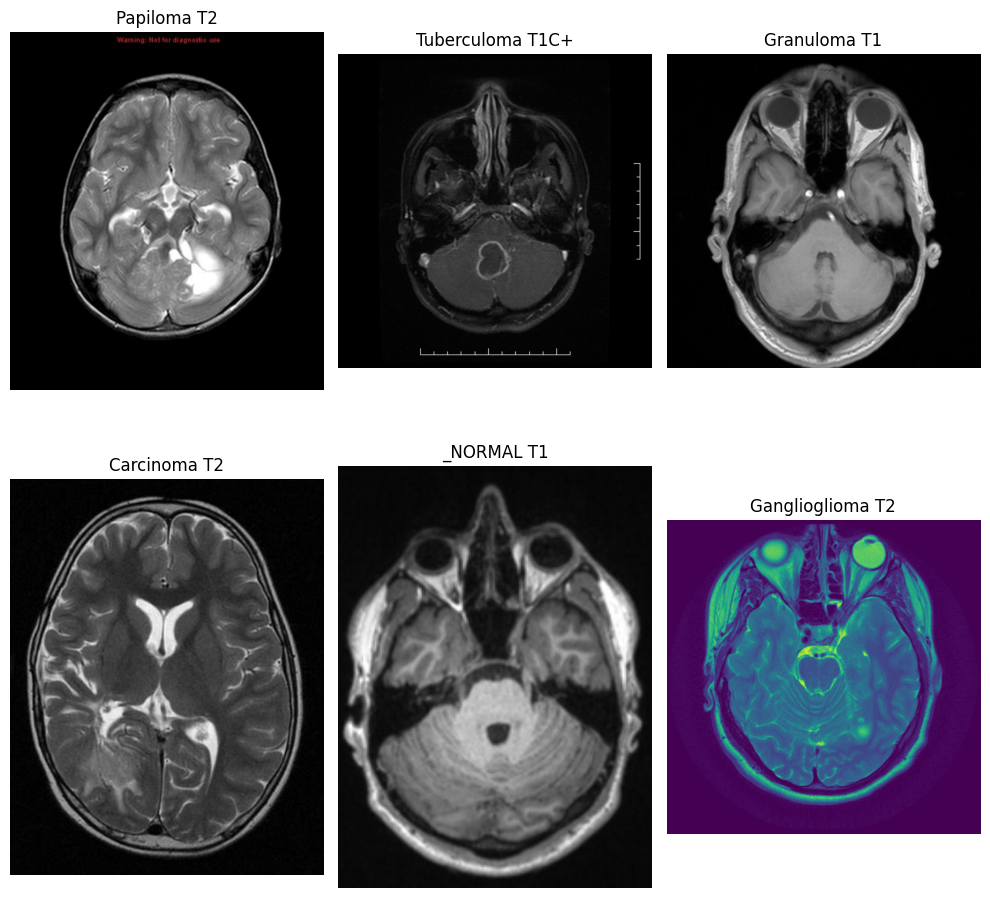

In [6]:
labels = df['label'].unique()
plt.figure(figsize=(10, 10))
for i, label in enumerate(labels[:6]):
    sample_path = df[df['label'] == label].sample(1).iloc[0]['image_path']
    img = Image.open(sample_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
num_duplicate_groups = df['hash'].duplicated().sum()
print(f"Number of duplicate images: {num_duplicate_groups}")

Number of duplicate images: 12


In [8]:
df.drop_duplicates(subset='hash', inplace=True)
print(f"Shape of DataFrame after removing duplicates: {df.shape}")

Shape of DataFrame after removing duplicates: (1241, 3)


In [9]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


In [10]:
!pip install torchinfo

In [11]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [12]:
data_dir = "/kaggle/input/brain-tumor-mri-images-44c"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1, random_state=seed).reset_index(drop=True)

In [13]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [14]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------\n")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  3135
Validation Data:  672
Test Data:  672
-------------------------------------------

Total amounts of data in the dataset:  4479


In [15]:
class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_df['label'].value_counts()

train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Train Dataset
Class                     Count
----------------------  -------
Meningioma T1C+             258
Meningioma T1               190
_NORMAL T2                  190
_NORMAL T1                  176
Meningioma T2               163
Astrocitoma T1C+            163
Neurocitoma T1C+            156
Schwannoma T1C+             136
Astrocitoma T1              123
Astrocitoma T2              120
Schwannoma T1               104
Neurocitoma T1               91
Schwannoma T2                86
Carcinoma T1C+               78
Papiloma T1C+                76
Neurocitoma T2               73
Glioblastoma T1C+            66
Oligodendroglioma T1         60
Tuberculoma T1C+             59
Carcinoma T2                 51
Oligodendroglioma T1C+       50
Meduloblastoma T1C+          47
Oligodendroglioma T2         46
Papiloma T1                  46
Carcinoma T1                 46
Papiloma T2                  44
Ependimoma T2                40
Glioblastoma T2              38
Glioblastoma T1           

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

In [18]:
label_map = {label: idx for idx, label in enumerate(sorted(df['label'].unique()))}

In [19]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, label_map, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = label_map

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path).convert("RGB") # Ensure 3 channels

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [20]:
train_batch = 32
val_batch = 8

def data_transfrom(label_map):
    normalize = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()])

    train_dataset = ImageDataset (
        train_dataframe,
        normalize,
        label_map,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        label_map,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        label_map,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom(label_map)

In [21]:
import torchvision.models as models

model = models.googlenet(pretrained=True)
total_class = len(df['label'].unique())
model.fc = nn.Linear(model.fc.in_features, total_class)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 76.7MB/s]


In [22]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=50, early_stop_patience=5, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print(f'Training Loss: {epoch_train_loss:.3f} Acc: {epoch_train_acc:.3f}')

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print(f'Validation Loss: {epoch_val_loss:.3f} Acc: {epoch_val_acc:.3f}')

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, save_path_checkpoints=save_path_checkpoints)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/50: 100%|██████████| 98/98 [00:17<00:00,  5.63it/s, acc=0.512, loss=1.86]

Training Loss: 1.861 Acc: 0.512


Validation Loss: 1.137 Acc: 0.665
Best model saved at epoch 1 with validation accuracy: 0.665


Epoch 2/50: 100%|██████████| 98/98 [00:13<00:00,  7.33it/s, acc=0.756, loss=0.835]

Training Loss: 0.835 Acc: 0.756


Validation Loss: 1.159 Acc: 0.659


Epoch 3/50: 100%|██████████| 98/98 [00:12<00:00,  7.63it/s, acc=0.857, loss=0.512]

Training Loss: 0.512 Acc: 0.857


Validation Loss: 0.841 Acc: 0.753
Best model saved at epoch 3 with validation accuracy: 0.753


Epoch 4/50: 100%|██████████| 98/98 [00:12<00:00,  7.97it/s, acc=0.912, loss=0.298]

Training Loss: 0.298 Acc: 0.912


Validation Loss: 0.683 Acc: 0.804
Best model saved at epoch 4 with validation accuracy: 0.804


Epoch 5/50: 100%|██████████| 98/98 [00:12<00:00,  7.62it/s, acc=0.917, loss=0.273]

Training Loss: 0.273 Acc: 0.917


Validation Loss: 1.492 Acc: 0.625


Epoch 6/50: 100%|██████████| 98/98 [00:12<00:00,  7.78it/s, acc=0.935, loss=0.222]

Training Loss: 0.222 Acc: 0.935


Validation Loss: 0.484 Acc: 0.859
Best model saved at epoch 6 with validation accuracy: 0.859
Early stopping criteria met. No improvement in validation accuracy or validation loss for 5 consecutive epochs. Training stopped.
Training Time: 100.40 seconds ---> 1.67 minutes


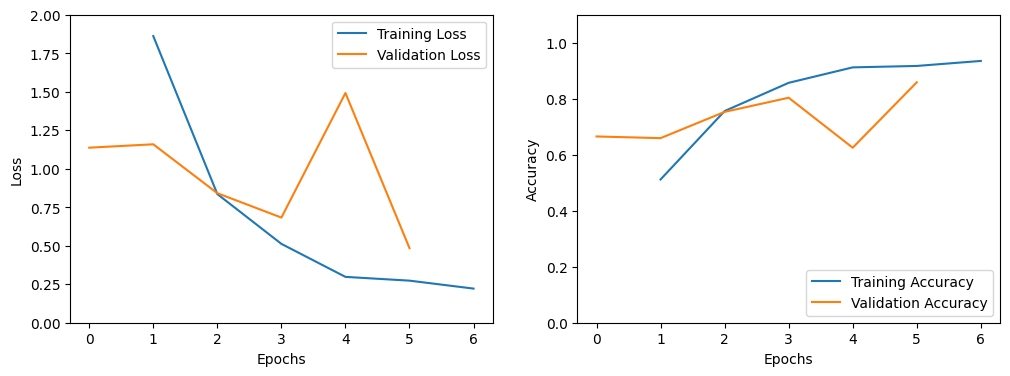

In [23]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

In [24]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [25]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 6) - Validation Loss: 0.484, Validation Accuracy: 0.859


In [26]:
start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.876
Test Time: 3.63 seconds ---> 0.06 minutes


In [27]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

inv_label_map = {v: k for k, v in label_map.items()}
class_names = [inv_label_map[i] for i in range(len(inv_label_map))]


print("Classification Report:")
# Use the actual class names as target_names
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
                        precision    recall  f1-score   support

        Astrocitoma T1       0.96      0.92      0.94        26
      Astrocitoma T1C+       0.94      0.86      0.90        35
        Astrocitoma T2       0.79      0.73      0.76        26
          Carcinoma T1       0.90      0.90      0.90        10
        Carcinoma T1C+       1.00      0.82      0.90        17
          Carcinoma T2       1.00      1.00      1.00        11
         Ependimoma T1       1.00      0.71      0.83         7
       Ependimoma T1C+       1.00      0.86      0.92         7
         Ependimoma T2       1.00      0.88      0.93         8
      Ganglioglioma T1       0.75      1.00      0.86         3
    Ganglioglioma T1C+       1.00      1.00      1.00         3
      Ganglioglioma T2       0.67      0.67      0.67         3
          Germinoma T1       0.80      1.00      0.89         4
        Germinoma T1C+       1.00      0.67      0.80         6
          Germin

In [28]:
class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i, class_name in enumerate(class_names):
    print(f"Accuracy for class '{class_name}': {class_acc[i]:.3f}")

Accuracy for class 'Astrocitoma T1': 0.923
Accuracy for class 'Astrocitoma T1C+': 0.857
Accuracy for class 'Astrocitoma T2': 0.731
Accuracy for class 'Carcinoma T1': 0.900
Accuracy for class 'Carcinoma T1C+': 0.824
Accuracy for class 'Carcinoma T2': 1.000
Accuracy for class 'Ependimoma T1': 0.714
Accuracy for class 'Ependimoma T1C+': 0.857
Accuracy for class 'Ependimoma T2': 0.875
Accuracy for class 'Ganglioglioma T1': 1.000
Accuracy for class 'Ganglioglioma T1C+': 1.000
Accuracy for class 'Ganglioglioma T2': 0.667
Accuracy for class 'Germinoma T1': 1.000
Accuracy for class 'Germinoma T1C+': 0.667
Accuracy for class 'Germinoma T2': 0.800
Accuracy for class 'Glioblastoma T1': 1.000
Accuracy for class 'Glioblastoma T1C+': 1.000
Accuracy for class 'Glioblastoma T2': 0.875
Accuracy for class 'Granuloma T1': 0.600
Accuracy for class 'Granuloma T1C+': 0.800
Accuracy for class 'Granuloma T2': 0.500
Accuracy for class 'Meduloblastoma T1': 1.000
Accuracy for class 'Meduloblastoma T1C+': 1.000
A